*********************************************************************************************************************
**Classification of credit card transactions:**
*********************************************************************************************************************

 
This project will try to classify credit card fraudulent/legitimate transactions.  I'm using SVM to build our model and will use cross-validation to check the fit of the model. After studying the dataset, it is clear that the data is skewed and will require proper resampling to train the model effectively.  I studied joparaga3' s model and referred his resampling technique to solve the skewed data problem.
 
My plan is to resample the data such that we have a balanced dataset, train our model and check the fit of our model for solving the problem and to choose the best parameters to use in our model. I have used Kaggle for studying many problems and this will be my first submission. Any advice or recommendation is appreciated. 

In [1]:
#importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


*********************************************************************************************************************
**Loading the Dataset**
*********************************************************************************************************************

In [2]:
data= pd.read_csv("../input/creditcard.csv")
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

 The dataset has 31 features. Most of the features are scaled and are
   results from PCA.  

The Amount column needs to be scaled and the Class column will be used as our dependent variable.
 Now let's visualize the Class feature to check the balance of features.

*********************************************************************************************************************
**Visualization of the "Class" feature**
*********************************************************************************************************************

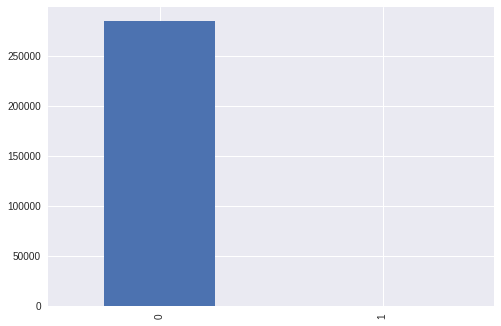

In [3]:
count_Class=pd.value_counts(data["Class"], sort= True)
count_Class.plot(kind= 'bar')

The dataset is highly unbalanced and is understandable. The Class 0 represents the normal transactions while Class 1 represents the fraudulent transactions.

*********************************************************************************************************************
**Let explore the "Class" feature to decide on the measure to solve this unbalance of data**
*********************************************************************************************************************

In [4]:
No_of_frauds= len(data[data["Class"]==1])
No_of_normals = len(data[data["Class"]==0])
print("The number of fraudulent transactions( Class 1) are: ", No_of_frauds)
print("The number of normal transactions( Class 0) are: ", No_of_normals)
total= No_of_frauds + No_of_normals
Fraud_percent= (No_of_frauds / total)*100
Normal_percent= (No_of_normals / total)*100
print("Class 0 percentage = ", Normal_percent)
print("Class 1 percentage = ", Fraud_percent)

The number of fraudulent transactions( Class 1) are:  492
The number of normal transactions( Class 0) are:  284315
Class 0 percentage =  99.82725143693798
Class 1 percentage =  0.1727485630620034


 1. It is clear that Class 1 is under-represented and accounts for only 0.17 % of the whole dataset. If we train our model using this dataset, the model will be inefficient and it will be trained to predict only Class 0 because it will not have sufficient training data. 
 2. One of the other problems of using this skewed dataset to train our model is that since Class 1 is under-represented, the model will assume that it is a rare case and will try to predict positive due to the lack of training data.
 3. We may get a high accuracy when we test our model but we should not be confused by this because our dataset does not have a balanced test data. Hence, we have to rely on the recall which relies on TP and FP.
 4. In cases where we have skewed data, adding additional data of the under-represented feature( over-sampling) is an option. Since we don't have that option we have to resort to under-sampling.
 5. Under-sampling of the dataset involves keeping all our under-represented data( Class 1) while adding the same number of features of Class 0 to create a new dataset comprising of an equal representation from both classes.

In [5]:
#list of fraud indices
fraud_index= np.array(data[data["Class"]==1].index)

#getting the list of normal indices from the full dataset
normal_index= data[data["Class"]==0].index

#choosing random normal indices equal to the number of fraudulent transactions
random_normal_indices= np.random.choice(normal_index, No_of_frauds, replace= False)
random_normal_indices= np.array(random_normal_indices)

# concatenate fraud index and normal index to create a list of indices
undersampled_indices= np.concatenate([fraud_index, random_normal_indices])

#use the undersampled indices to build the undersampled_data dataframe
undersampled_data= data.iloc[undersampled_indices, :]

print(undersampled_data.head())

        Time        V1        V2        V3        V4        V5        V6  \
541    406.0 -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545   
623    472.0 -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823   
4920  4462.0 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788   
6108  6986.0 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536   
6329  7519.0  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746   

            V7        V8        V9  ...         V21       V22       V23  \
541  -2.537387  1.391657 -2.770089  ...    0.517232 -0.035049 -0.465211   
623   0.325574 -0.067794 -0.270953  ...    0.661696  0.435477  1.375966   
4920  0.562320 -0.399147 -0.238253  ...   -0.294166 -0.932391  0.172726   
6108 -3.496197 -0.248778 -0.247768  ...    0.573574  0.176968 -0.436207   
6329  1.713445 -0.496358 -1.282858  ...   -0.379068 -0.704181 -0.656805   

           V24       V25       V26       V27       V28  Amount  Class  
541   0.320198  0.04

*********************************************************************************************************************
**Let explore the Undersampled data**
*********************************************************************************************************************

The number of fraudulent transactions( Class 1) are:  492
The number of normal transactions( Class 0) are:  492
The total number of rows of both classes are:  984
Class 0 percentage =  50.0
Class 1 percentage =  50.0


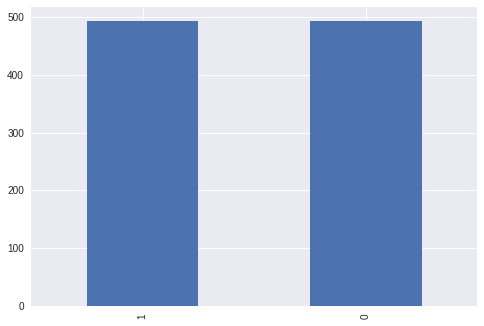

In [6]:
No_of_frauds_sampled= len(undersampled_data[undersampled_data["Class"]== 1])

No_of_normals_sampled = len(undersampled_data[undersampled_data["Class"]== 0])

print("The number of fraudulent transactions( Class 1) are: ", No_of_frauds_sampled)
print("The number of normal transactions( Class 0) are: ", No_of_normals_sampled)
total_sampled= No_of_frauds_sampled + No_of_normals_sampled
print("The total number of rows of both classes are: ", total_sampled)

Fraud_percent_sampled= (No_of_frauds_sampled / total_sampled)*100
Normal_percent_sampled= (No_of_normals_sampled / total_sampled)*100
print("Class 0 percentage = ", Normal_percent_sampled)
print("Class 1 percentage = ", Fraud_percent_sampled)

#Check the data count now
count_sampled=pd.value_counts(undersampled_data["Class"], sort= True)
count_sampled.plot(kind= 'bar')

So, we have to train/test our model using 984 rows of data. It is not much but it will have to suffice. Let's find out if we can generate good predictions using this dataset.

*********************************************************************************************************************
**Scaling the Undersampled_data:** 
*********************************************************************************************************************

In [7]:
#We have to scale the Amount feature before fitting our model to our dataset

sc= StandardScaler()
undersampled_data["scaled_Amount"]=  sc.fit_transform(undersampled_data.iloc[:,29].values.reshape(-1,1))

#dropping time and old amount column
undersampled_data= undersampled_data.drop(["Time","Amount"], axis= 1)

print(undersampled_data.head())

            V1        V2        V3        V4        V5        V6        V7  \
541  -2.312227  1.951992 -1.609851  3.997906 -0.522188 -1.426545 -2.537387   
623  -3.043541 -3.157307  1.088463  2.288644  1.359805 -1.064823  0.325574   
4920 -2.303350  1.759247 -0.359745  2.330243 -0.821628 -0.075788  0.562320   
6108 -4.397974  1.358367 -2.592844  2.679787 -1.128131 -1.706536 -3.496197   
6329  1.234235  3.019740 -4.304597  4.732795  3.624201 -1.357746  1.713445   

            V8        V9       V10      ...             V21       V22  \
541   1.391657 -2.770089 -2.772272      ...        0.517232 -0.035049   
623  -0.067794 -0.270953 -0.838587      ...        0.661696  0.435477   
4920 -0.399147 -0.238253 -1.525412      ...       -0.294166 -0.932391   
6108 -0.248778 -0.247768 -4.801637      ...        0.573574  0.176968   
6329 -0.496358 -1.282858 -2.447469      ...       -0.379068 -0.704181   

           V23       V24       V25       V26       V27       V28  Class  \
541  -0.465211  0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.



*********************************************************************************************************************
**Separating the dependent and independent variables**
*********************************************************************************************************************



In [8]:
X= undersampled_data.iloc[:, undersampled_data.columns != "Class"].values

y= undersampled_data.iloc[:, undersampled_data.columns == "Class"].values



*********************************************************************************************************************
**Splitting the undersampled data into training set and test set**
*********************************************************************************************************************

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 0)
print("The split of the under_sampled data is as follows")
print("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

The split of the under_sampled data is as follows
X_train:  738
X_test:  246
y_train:  738
y_test:  246


*********************************************************************************************************************
**SVM- Fitting our dataset to the classifier**
*********************************************************************************************************************

In [10]:
#Using the gaussian kernel to build the initail model. Let us see if this is the best parameter later
classifier= SVC(C= 1, kernel= 'rbf', random_state= 0)
classifier.fit(X_train, y_train.ravel())


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

*********************************************************************************************************************
**Predicting the class by fitting X_test to our classifier**
*********************************************************************************************************************

In [11]:
#Predict the class using X_test
y_pred = classifier.predict(X_test)

*********************************************************************************************************************
**The Confusion matrix**
*********************************************************************************************************************

The Confusion matrix can be used to calculate the accuracy, recall, and precision from our model.  Let us fit our confusion matrix class with y_pred(predicted results) and y_test( actual results)

In [12]:
#cm1 is the confusion matrix 1 which uses the undersampled dataset
cm1 = confusion_matrix(y_test, y_pred)



*********************************************************************************************************************
**Visualizing the confusion matrix using mlxtend library**
*********************************************************************************************************************

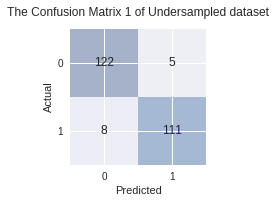

The accuracy is 94.7154471545 %
The recall from the confusion matrix is 93.2773109244 %


In [13]:
def confusion_matrix_1(CM):
    fig, ax = plot_confusion_matrix(conf_mat=CM)
    plt.title("The Confusion Matrix 1 of Undersampled dataset")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")
confusion_matrix_1(cm1)

We have good accuracy and recall score so our model is giving good results when using the undersampled data. The real test will be when we apply the model to our whole dataset(skewed).

*********************************************************************************************************************
**Applying Cross Validation to determine accuracy of our model**
*********************************************************************************************************************

In [14]:
#Applying 10 fold cross validation
accuracies = cross_val_score(estimator = classifier, X=X_train, y = y_train.ravel(), cv = 10)
mean_accuracy= accuracies.mean()*100
std_accuracy= accuracies.std()*100
print("The mean accuracy in %: ", accuracies.mean()*100)
print("The standard deviation in % ", accuracies.std()*100)
print("The accuracy of our model in % is betweeen {} and {}".format(mean_accuracy-std_accuracy, mean_accuracy+std_accuracy))

The mean accuracy in %:  93.1016166852
The standard deviation in %  2.69435919238
The accuracy of our model in % is betweeen 90.40725749279737 and 95.79597587755929


*********************************************************************************************************************
**Applying GridSearch to find if our model is the best fit and also to determine the best parameters to train our model.** 
*********************************************************************************************************************

In [15]:
#applying gridsearchCV to our classifier
#Specifying the parameters in dictionaries to try out different parameters.
#The GridSearchCV will try all the parameters and give us the best parameters

parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train.ravel())
best_accuracy = grid_search.best_score_
print("The best accuracy using gridSearch is", best_accuracy)

best_parameters = grid_search.best_params_
print("The best parameters for using this model is", best_parameters)

The best accuracy using gridSearch is 0.934959349593
The best parameters for using this model is {'C': 1, 'kernel': 'linear'}


*********************************************************************************************************************
**Now we use the best parameters to train the SVM classifier:**
*********************************************************************************************************************

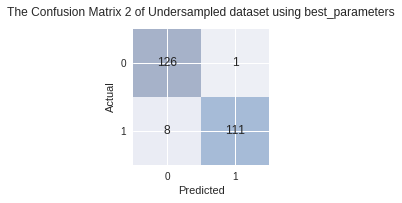

The accuracy is 96.3414634146 %
The recall from the confusion matrix is 93.2773109244 %


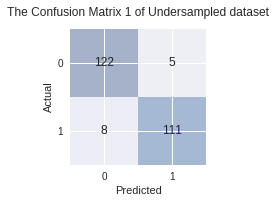

The accuracy is 94.7154471545 %
The recall from the confusion matrix is 93.2773109244 %


In [16]:
#fitting the model with the best parameters
classifier_with_best_parameters =  SVC(C= best_parameters["C"], kernel= best_parameters["kernel"], random_state= 0)
classifier_with_best_parameters.fit(X_train, y_train.ravel())
#predicting the Class 
y_pred_best_parameters = classifier_with_best_parameters.predict(X_test)
#creating a confusion matrix
#cm2 is the confusion matrix  which uses the best parameters
cm2 = confusion_matrix(y_test, y_pred_best_parameters)
#visualizing the confusion matrix
def confusion_matrix_2(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM)
    plt.title("The Confusion Matrix 2 of Undersampled dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) + " %")
confusion_matrix_2(cm2)
#also printing the confusion matrix 1 for comparison
confusion_matrix_1(cm1)


The accuracy of our model has improved by using the best_parameters.  We were able to classify more samples in the True negative region. We can re-run the models by using different range values of C to improve the accuracy, but I'm quite happy with both the recall and the accuracy. Now its time to test our model with the whole dataset.

*********************************************************************************************************************
**Testing the model against the full dataset(skewed)**
*********************************************************************************************************************

In [17]:
#creating a new dataset to test our model
datanew= data.copy()

#Now to test the model with the whole dataset
datanew["scaled_Amount"]=  sc.fit_transform(datanew["Amount"].values.reshape(-1,1))

#dropping time and old amount column
datanew= datanew.drop(["Time","Amount"], axis= 1)

#separating the x and y variables to fit our model
X_full= datanew.iloc[:, undersampled_data.columns != "Class"].values

y_full= datanew.iloc[:, undersampled_data.columns == "Class"].values




*********************************************************************************************************************
**Splitting the full dataset into training and test set**
*********************************************************************************************************************


In [18]:
#splitting the full dataset into training and test set
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size= 0.25, random_state= 0)

print("The split of the full dataset is as follows")
print("X_train_full: ", len(X_train_full))
print("X_test_full: ", len(X_test_full))
print("y_train_full: ", len(y_train_full))
print("y_test_full: ", len(y_test_full))

The split of the full dataset is as follows
X_train_full:  213605
X_test_full:  71202
y_train_full:  213605
y_test_full:  71202


*********************************************************************************************************************
**Predicting y_pred, ie. our class value using X_test_full**
*********************************************************************************************************************

In [19]:
#predicting y_pred_full_dataset
y_pred_full_dataset= classifier_with_best_parameters.predict(X_test_full)

#confusion matrix usign y_test_full and ypred_full
cm3 = confusion_matrix(y_test_full, y_pred_full_dataset)

*********************************************************************************************************************
**Plotting the Confusion matrix 3 and comparing it with Confusion matrix 2 ( the one with the best parameters)**
*********************************************************************************************************************

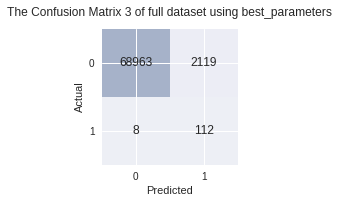

The accuracy is 97.0127243617 %
The recall from the confusion matrix is 93.3333333333 %


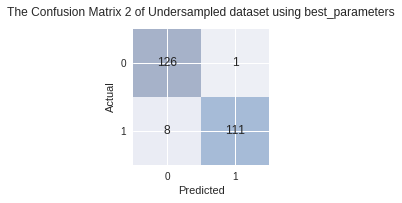

The accuracy is 96.3414634146 %
The recall from the confusion matrix is 93.2773109244 %


In [20]:
def confusion_matrix_3(CM):
    fig, ax = plot_confusion_matrix(conf_mat= CM)
    plt.title("The Confusion Matrix 3 of full dataset using best_parameters")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    print("The accuracy is "+str((CM[1,1]+CM[0,0])/(CM[0,0] + CM[0,1]+CM[1,0] + CM[1,1])*100) + " %")
    print("The recall from the confusion matrix is "+ str(CM[1,1]/(CM[1,0] + CM[1,1])*100) +" %")
confusion_matrix_3(cm3)

#printing confusion matrix 2 for comparison with training set results
confusion_matrix_2(cm2)

By fitting our model to the whole dataset, we have obtained similar accuracy and recall as our training set results. I'm quite happy with the results although I believe we can further improve the model by having more training data and also by either using a better algorithm or by modifying our parameters. I will try implementing the same using decision trees, ANN and compare the results. This is my first Kaggle submission and I'd appreciate any suggestions to improve my model. Thanks!